In [36]:
import pandas as pd
import numpy as np
import os
import glob
from datetime import datetime

# Configurações
RAW_PATH = r'C:\Users\Enzo\Documents\Projetos\projeto_desigualdade\data\raw\ibge'
PROCESSED_PATH = r'C:\Users\Enzo\Documents\Projetos\projeto_desigualdade\data\processed'

def limpeza_final_ibge():
    """Limpeza final especializada para estrutura IBGE"""
    
    print("🚀 LIMPEZA FINAL - ESTRUTURA IBGE")
    print("="*80)
    
    # Mapeamento de significado das colunas IBGE
    MAPEAMENTO_IBGE = {
        'NC': 'nivel_territorial_codigo',
        'NN': 'nivel_territorial_nome', 
        'MC': 'unidade_medida_codigo',
        'MN': 'unidade_medida_nome',
        'V': 'valor',
        'D1C': 'dimensao1_codigo',
        'D1N': 'dimensao1_nome',
        'D2C': 'dimensao2_codigo', 
        'D2N': 'dimensao2_nome',
        'D3C': 'dimensao3_codigo',
        'D3N': 'dimensao3_nome',
        'D4C': 'dimensao4_codigo',
        'D4N': 'dimensao4_nome',
        'D5C': 'dimensao5_codigo',
        'D5N': 'dimensao5_nome'
    }
    
    arquivos_processados = {}
    
    for arquivo in glob.glob(os.path.join(RAW_PATH, "*.csv")):
        nome_arquivo = os.path.basename(arquivo)
        print(f"\n📁 PROCESSANDO: {nome_arquivo}")
        
        try:
            # Ler arquivo
            df = pd.read_csv(arquivo, sep=',', encoding='utf-8')
            print(f"   Dimensões originais: {df.shape}")
            
            # 1. APLICAR MAPEAMENTO DE COLUNAS IBGE
            mapeamento_aplicar = {col: MAPEAMENTO_IBGE[col] for col in df.columns if col in MAPEAMENTO_IBGE}
            df = df.rename(columns=mapeamento_aplicar)
            print(f"   Colunas renomeadas: {len(mapeamento_aplicar)}")
            
            # 2. TRATAMENTO DA COLUNA VALOR
            if 'valor' in df.columns:
                # Converter valores com ".." para NaN (dados não disponíveis)
                df['valor'] = df['valor'].replace('..', np.nan)
                
                # Tentar converter para numérico
                df['valor_convertido'] = pd.to_numeric(df['valor'], errors='coerce')
                
                # Verificar se conversão foi bem sucedida
                convertidos = df['valor_convertido'].notna().sum()
                print(f"   Valores convertidos para numérico: {convertidos}/{len(df)}")
            
            # 3. IDENTIFICAR TIPO DE ANÁLISE PELO NOME DO ARQUIVO
            if 'renda' in nome_arquivo.lower():
                tipo = 'renda'
                # Processamento específico para dados de renda
                df = processar_dados_renda(df, nome_arquivo)
            elif 'despesas' in nome_arquivo.lower() or 'consumo' in nome_arquivo.lower():
                tipo = 'despesas'
                df = processar_dados_despesas(df, nome_arquivo)
            elif 'emprego' in nome_arquivo.lower():
                tipo = 'emprego'
                df = processar_dados_emprego(df, nome_arquivo)
            elif 'educacao' in nome_arquivo.lower():
                tipo = 'educacao'
            elif 'trabalho' in nome_arquivo.lower():
                tipo = 'trabalho'
            elif 'bens' in nome_arquivo.lower():
                tipo = 'bens'
                df = processar_dados_bens(df, nome_arquivo)
            else:
                tipo = 'geral'
            
            # 4. IDENTIFICAR VARIÁVEIS RELEVANTES
            if 'dimensao3_nome' in df.columns:
                variaveis_unicas = df['dimensao3_nome'].unique()
                print(f"   Variáveis encontradas: {list(variaveis_unicas[:5])}")  # Mostrar primeiras 5
            
            # 5. SALVAR DADOS PROCESSADOS
            nome_saida = f"{os.path.splitext(nome_arquivo)[0]}_processado.csv"
            caminho_saida = os.path.join(PROCESSED_PATH, nome_saida)
            df.to_csv(caminho_saida, index=False, encoding='utf-8')
            
            arquivos_processados[nome_arquivo] = {
                'dataframe': df,
                'tipo': tipo,
                'caminho': caminho_saida
            }
            
            print(f"   ✅ Salvo: {caminho_saida}")
            
        except Exception as e:
            print(f"   ❌ Erro: {str(e)}")
    
    return arquivos_processados

def processar_dados_renda(df, nome_arquivo):
    """Processamento específico para dados de renda"""
    print(f"   💰 Processamento RENDA: {nome_arquivo}")
    
    # Identificar se tem dados de renda domiciliar
    if 'dimensao3_nome' in df.columns:
        variaveis_renda = df[df['dimensao3_nome'].str.contains('renda|salário|income', case=False, na=False)]
        if not variaveis_renda.empty:
            print(f"      Variáveis de renda encontradas: {len(variaveis_renda)}")
    
    return df

def processar_dados_despesas(df, nome_arquivo):
    """Processamento específico para dados de despesas"""
    print(f"   🛒 Processamento DESPESAS: {nome_arquivo}")
    
    if 'dimensao3_nome' in df.columns:
        variaveis_despesas = df[df['dimensao3_nome'].str.contains('despesa|gasto|consumo', case=False, na=False)]
        if not variaveis_despesas.empty:
            print(f"      Variáveis de despesas encontradas: {len(variaveis_despesas)}")
    
    return df

def processar_dados_emprego(df, nome_arquivo):
    """Processamento específico para dados de emprego"""
    print(f"   💼 Processamento EMPREGO: {nome_arquivo}")
    
    if 'dimensao3_nome' in df.columns:
        variaveis_emprego = df[df['dimensao3_nome'].str.contains('desocupação|emprego|ocupação|informalidade', case=False, na=False)]
        if not variaveis_emprego.empty:
            print(f"      Variáveis de emprego encontradas: {len(variaveis_emprego)}")
    
    return df

def processar_dados_bens(df, nome_arquivo):
    """Processamento específico para dados de posse de bens"""
    print(f"   🏠 Processamento BENS: {nome_arquivo}")
    
    if 'dimensao3_nome' in df.columns:
        variaveis_bens = df[df['dimensao3_nome'].str.contains('PIB|consumo|vendas', case=False, na=False)]
        if not variaveis_bens.empty:
            print(f"      Variáveis econômicas encontradas: {len(variaveis_bens)}")
    
    return df

def criar_dataset_consolidado(arquivos_processados):
    """Cria um dataset consolidado para análise"""
    
    print(f"\n🔗 CRIANDO DATASET CONSOLIDADO")
    
    datasets_consolidar = []
    
    for nome_arquivo, info in arquivos_processados.items():
        df = info['dataframe']
        tipo = info['tipo']
        
        # Adicionar coluna identificadora
        df['fonte_arquivo'] = nome_arquivo
        df['tipo_dado'] = tipo
        
        datasets_consolidar.append(df)
    
    if datasets_consolidar:
        df_consolidado = pd.concat(datasets_consolidar, ignore_index=True)
        
        caminho_consolidado = os.path.join(PROCESSED_PATH, "dados_ibge_consolidado.csv")
        df_consolidado.to_csv(caminho_consolidado, index=False, encoding='utf-8')
        
        print(f"   ✅ Dataset consolidado salvo: {caminho_consolidado}")
        print(f"   📊 Dimensões: {df_consolidado.shape}")
        
        return df_consolidado
    
    return None

def gerar_relatorio_final(arquivos_processados):
    """Gera relatório final da limpeza"""
    
    print(f"\n📊 RELATÓRIO FINAL DA LIMPEZA")
    print("="*80)
    
    total_linhas = 0
    total_colunas = 0
    
    for nome_arquivo, info in arquivos_processados.items():
        df = info['dataframe']
        print(f"\n📁 {nome_arquivo}:")
        print(f"   Tipo: {info['tipo']}")
        print(f"   Dimensões: {df.shape}")
        print(f"   Colunas: {list(df.columns)}")
        
        if 'valor_convertido' in df.columns:
            valores_validos = df['valor_convertido'].notna().sum()
            print(f"   Valores numéricos: {valores_validos}/{len(df)}")
        
        total_linhas += len(df)
        total_colunas += len(df.columns)
    
    print(f"\n📈 TOTAIS:")
    print(f"   Arquivos processados: {len(arquivos_processados)}")
    print(f"   Total de linhas: {total_linhas}")
    print(f"   Total de colunas: {total_colunas}")

# EXECUÇÃO PRINCIPAL
def main():
    """Executa a limpeza final"""
    
    print("🚀 INICIANDO LIMPEZA FINAL DOS DADOS IBGE")
    print("="*80)
    
    # 1. Limpeza final
    arquivos_processados = limpeza_final_ibge()
    
    # 2. Dataset consolidado
    df_consolidado = criar_dataset_consolidado(arquivos_processados)
    
    # 3. Relatório final
    gerar_relatorio_final(arquivos_processados)
    
    print(f"\n🎉 LIMPEZA CONCLUÍDA COM SUCESSO!")
    print(f"📁 Arquivos processados: {len(arquivos_processados)}")
    
    return arquivos_processados, df_consolidado

if __name__ == "__main__":
    arquivos_processados, df_consolidado = main()

🚀 INICIANDO LIMPEZA FINAL DOS DADOS IBGE
🚀 LIMPEZA FINAL - ESTRUTURA IBGE

📁 PROCESSANDO: censo2022_educacao_raw.csv
   Dimensões originais: (163, 13)
   Colunas renomeadas: 13
   Valores convertidos para numérico: 150/163
   Variáveis encontradas: ['Variável', 'Índice de envelhecimento da população residente em terras indígenas (Idosos: 60 anos ou mais de idade)', 'Idade mediana da população residente em terras indígenas', 'Razão de sexo da população residente em terras indígenas', 'Índice de envelhecimento da população indígena residente em terras indígenas (Idosos: 60 anos ou mais de idade)']
   ✅ Salvo: C:\Users\Enzo\Documents\Projetos\projeto_desigualdade\data\processed\censo2022_educacao_raw_processado.csv

📁 PROCESSANDO: censo2022_renda_domiciliar_raw.csv
   Dimensões originais: (5, 15)
   Colunas renomeadas: 15
   Valores convertidos para numérico: 3/5
   💰 Processamento RENDA: censo2022_renda_domiciliar_raw.csv
   Variáveis encontradas: ['Variável', 'Pessoas de 10 anos ou mais

📊 INICIANDO ANÁLISE EXPLORATÓRIA DE DESIGUALDADE ECONÔMICA
🚀 INICIANDO ANÁLISE EXPLORATÓRIA DE DESIGUALDADE ECONÔMICA
1. 📈 VISÃO GERAL DO DATASET:
   Dimensões: (1408, 18)
   Colunas: ['nivel_territorial_codigo', 'nivel_territorial_nome', 'unidade_medida_codigo', 'unidade_medida_nome', 'valor', 'dimensao1_codigo', 'dimensao1_nome', 'dimensao2_codigo', 'dimensao2_nome', 'dimensao3_codigo', 'dimensao3_nome', 'dimensao4_codigo', 'dimensao4_nome', 'valor_convertido', 'fonte_arquivo', 'tipo_dado', 'dimensao5_codigo', 'dimensao5_nome']
   Tipos de dados:
object     17
float64     1
Name: count, dtype: int64

2. 🗂️ DISTRIBUIÇÃO POR TIPO DE DADO:
tipo_dado
renda       484
despesas    458
educacao    163
trabalho    163
geral        99
bens         41
Name: count, dtype: int64

3. 📍 DISTRIBUIÇÃO TERRITORIAL:
nivel_territorial_nome
Brasil                  1075
Unidade da Federação     324
Nível Territorial          9
Name: count, dtype: int64

4. 💰 ANÁLISE DE VARIÁVEIS DE RENDA:
   Total de obse

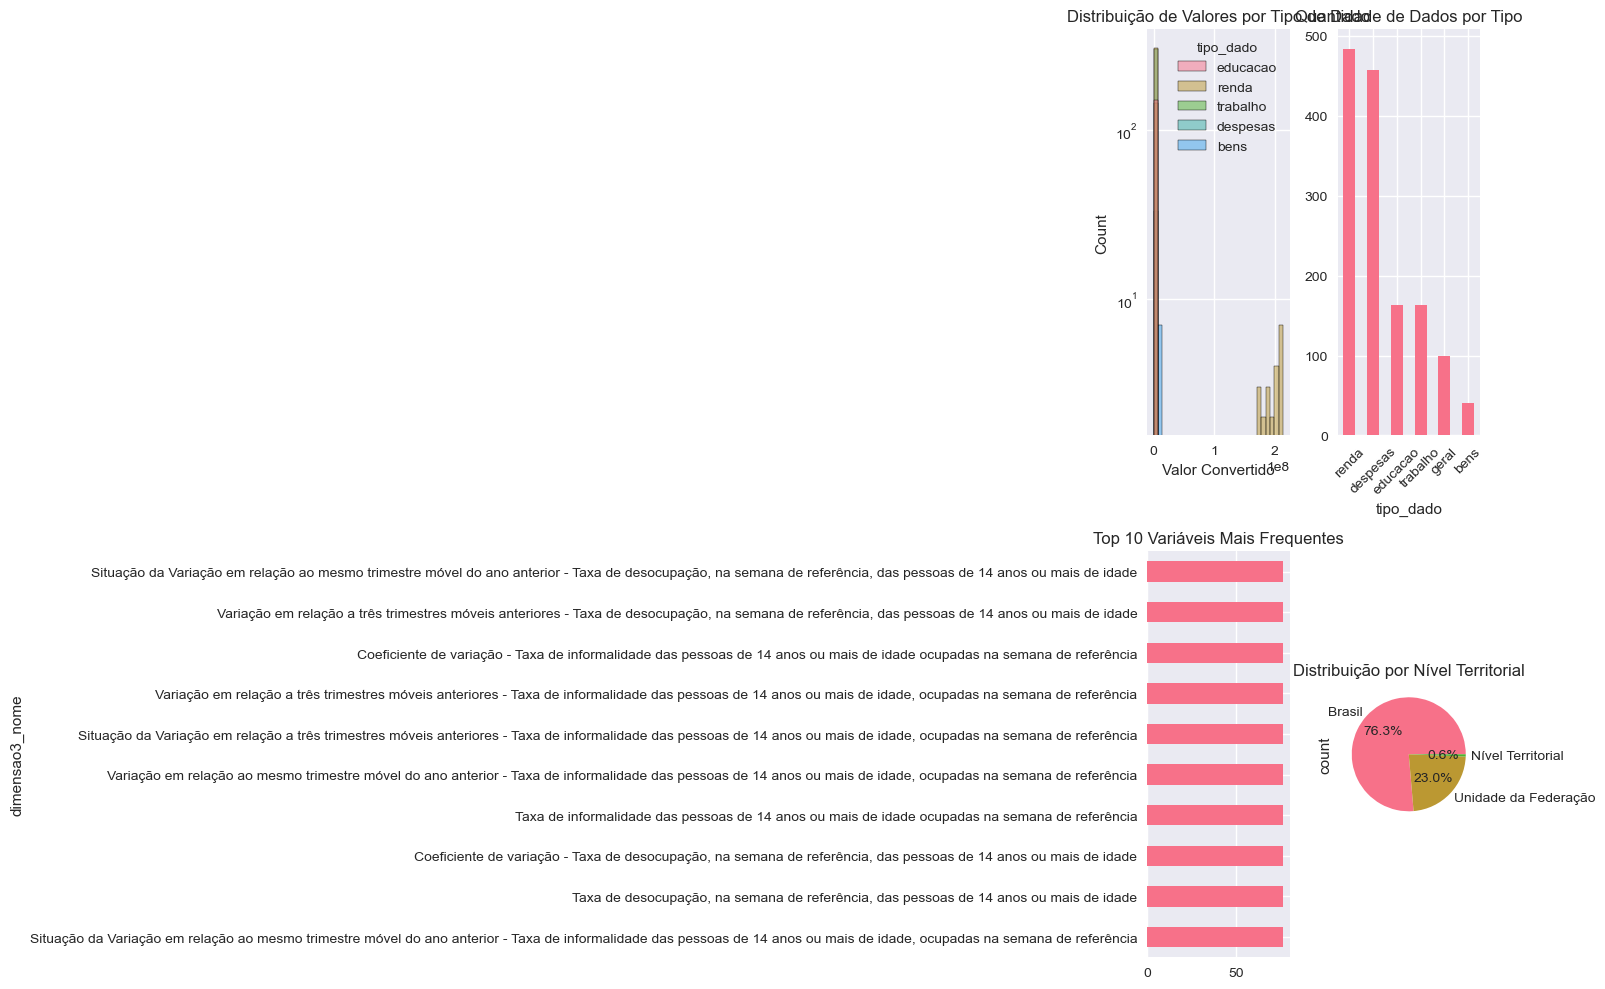

   📈 Analisando séries temporais...


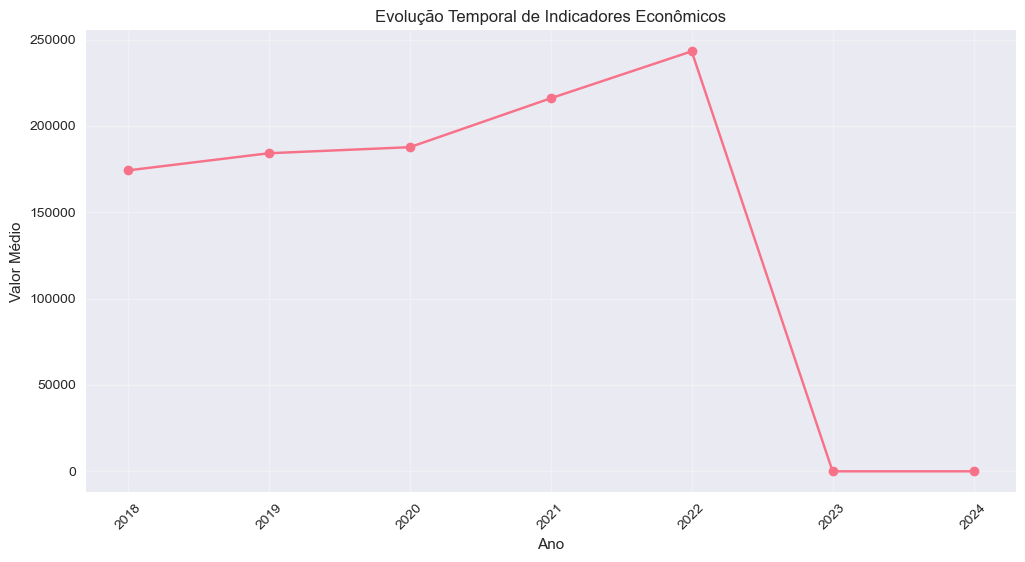

   📊 Criando visualizações de desigualdade...


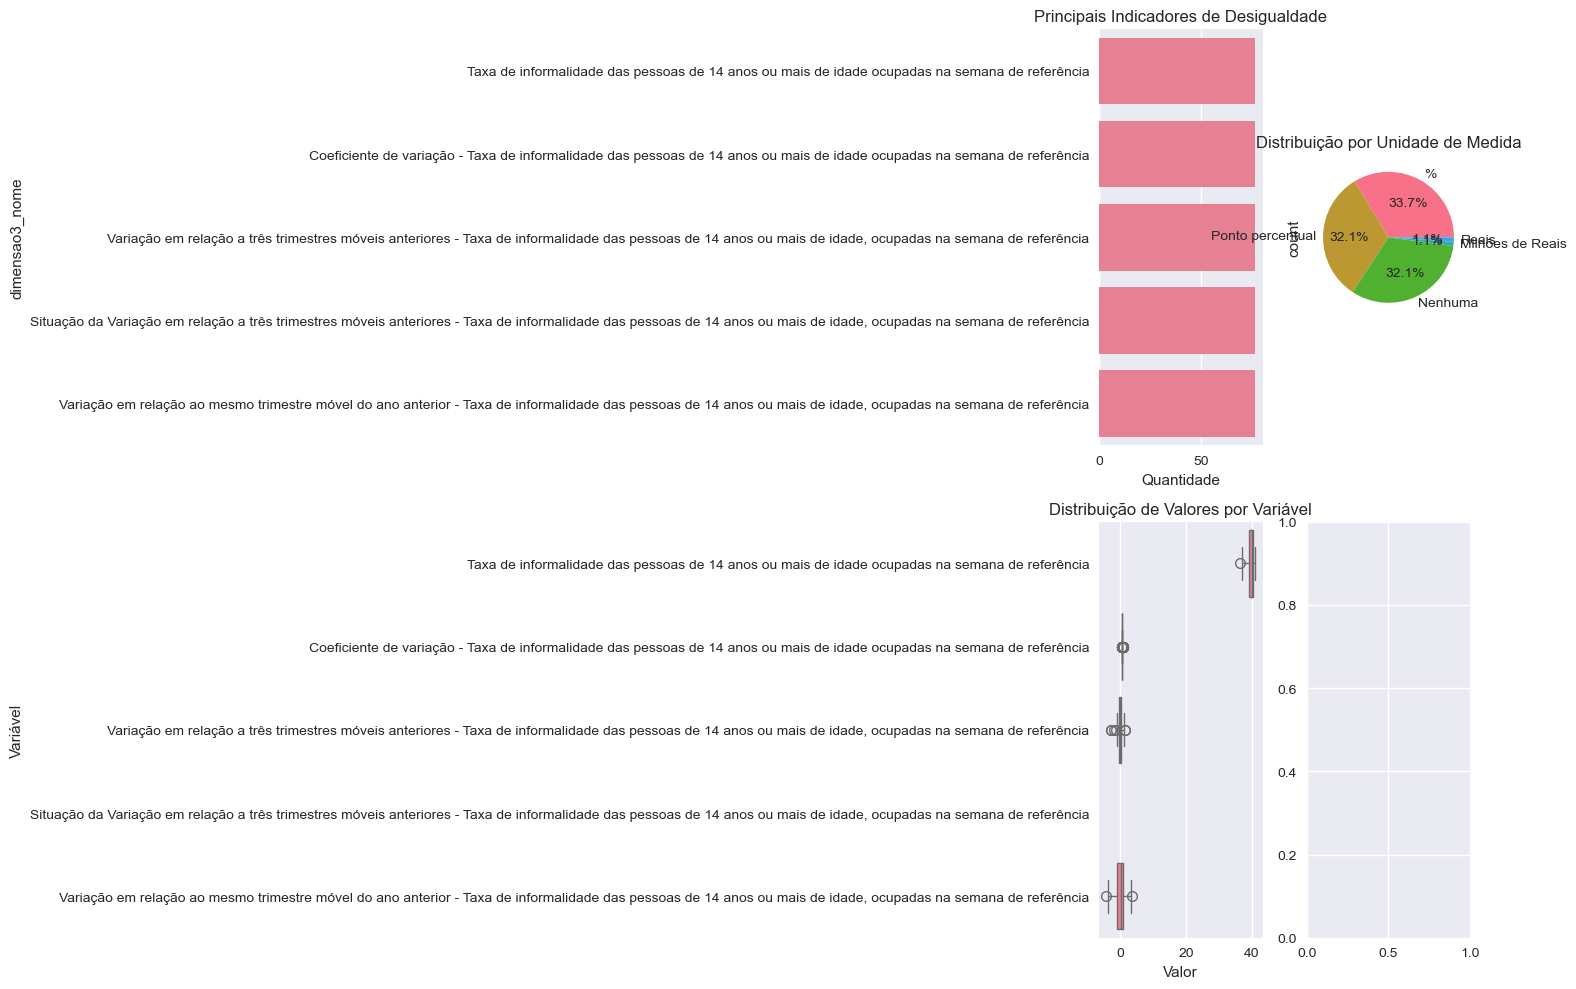


6. 📋 RELATÓRIO DA ANÁLISE EXPLORATÓRIA:
✅ DADOS PROCESSADOS COM SUCESSO
   • Dataset consolidado: (1408, 18)
   • Tipos de dados analisados: 6
   • Variáveis únicas: 40

🎯 PRÓXIMOS PASSOS PARA ANÁLISE DE DESIGUALDADE:
   1. Calcular índices de desigualdade (Gini, Theil)
   2. Análise regional (Norte vs Sul, capitais vs interior)
   3. Análise temporal da evolução da desigualdade
   4. Correlação entre educação, renda e desigualdade
   5. Criar dashboard interativo com Power BI/Tableau

🎉 ANÁLISE EXPLORATÓRIA CONCLUÍDA!
📁 Gráficos salvos em: C:\Users\Enzo\Documents\Projetos\projeto_desigualdade\data\processed\plots


In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os

# Configurações de visualização
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

# Carregar dados consolidados
PROCESSED_PATH = r'C:\Users\Enzo\Documents\Projetos\projeto_desigualdade\data\processed'
df_consolidado = pd.read_csv(os.path.join(PROCESSED_PATH, "dados_ibge_consolidado.csv"))

print("📊 INICIANDO ANÁLISE EXPLORATÓRIA DE DESIGUALDADE ECONÔMICA")
print("="*80)

def analise_geral_dataset():
    """Análise geral do dataset consolidado"""
    
    print("1. 📈 VISÃO GERAL DO DATASET:")
    print(f"   Dimensões: {df_consolidado.shape}")
    print(f"   Colunas: {list(df_consolidado.columns)}")
    print(f"   Tipos de dados:\n{df_consolidado.dtypes.value_counts()}")
    
    print(f"\n2. 🗂️ DISTRIBUIÇÃO POR TIPO DE DADO:")
    print(df_consolidado['tipo_dado'].value_counts())
    
    print(f"\n3. 📍 DISTRIBUIÇÃO TERRITORIAL:")
    if 'nivel_territorial_nome' in df_consolidado.columns:
        print(df_consolidado['nivel_territorial_nome'].value_counts().head(10))

def analise_variaveis_renda():
    """Análise específica das variáveis de renda"""
    
    print("\n4. 💰 ANÁLISE DE VARIÁVEIS DE RENDA:")
    
    # Filtrar dados de renda
    dados_renda = df_consolidado[df_consolidado['tipo_dado'].isin(['renda', 'emprego'])]
    
    if not dados_renda.empty:
        print(f"   Total de observações de renda: {len(dados_renda)}")
        
        # Variáveis mais comuns
        if 'dimensao3_nome' in dados_renda.columns:
            variaveis_renda = dados_renda['dimensao3_nome'].value_counts().head(10)
            print(f"   Principais variáveis:\n{variaveis_renda}")
        
        # Análise de valores numéricos
        if 'valor_convertido' in dados_renda.columns:
            valores_numericos = dados_renda['valor_convertido'].dropna()
            if not valores_numericos.empty:
                print(f"\n   Estatísticas dos valores de renda:")
                print(f"   Média: R$ {valores_numericos.mean():.2f}")
                print(f"   Mediana: R$ {valores_numericos.median():.2f}")
                print(f"   Min: R$ {valores_numericos.min():.2f}")
                print(f"   Max: R$ {valores_numericos.max():.2f}")
                print(f"   Desvio Padrão: R$ {valores_numericos.std():.2f}")

def criar_visualizacoes_desigualdade():
    """Cria visualizações para análise de desigualdade"""
    
    print("\n5. 📊 CRIANDO VISUALIZAÇÕES:")
    
    # Configurar diretório para salvar gráficos
    plots_path = os.path.join(PROCESSED_PATH, "plots")
    os.makedirs(plots_path, exist_ok=True)
    
    # 5.1 Distribuição de valores por tipo de dado
    plt.figure(figsize=(15, 10))
    
    # Subplot 1: Distribuição de valores numéricos
    plt.subplot(2, 2, 1)
    dados_numericos = df_consolidado[df_consolidado['valor_convertido'].notna()]
    if not dados_numericos.empty:
        sns.histplot(data=dados_numericos, x='valor_convertido', hue='tipo_dado', bins=30)
        plt.title('Distribuição de Valores por Tipo de Dado')
        plt.xlabel('Valor Convertido')
        plt.yscale('log')  # Escala log para melhor visualização
    
    # Subplot 2: Contagem por tipo de dado
    plt.subplot(2, 2, 2)
    df_consolidado['tipo_dado'].value_counts().plot(kind='bar')
    plt.title('Quantidade de Dados por Tipo')
    plt.xticks(rotation=45)
    
    # Subplot 3: Top variáveis mais frequentes
    plt.subplot(2, 2, 3)
    if 'dimensao3_nome' in df_consolidado.columns:
        top_variaveis = df_consolidado['dimensao3_nome'].value_counts().head(10)
        top_variaveis.plot(kind='barh')
        plt.title('Top 10 Variáveis Mais Frequentes')
    
    # Subplot 4: Valores por nível territorial
    plt.subplot(2, 2, 4)
    if 'nivel_territorial_nome' in df_consolidado.columns:
        territorial_counts = df_consolidado['nivel_territorial_nome'].value_counts().head(8)
        territorial_counts.plot(kind='pie', autopct='%1.1f%%')
        plt.title('Distribuição por Nível Territorial')
    
    plt.tight_layout()
    plt.savefig(os.path.join(plots_path, 'analise_geral.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    # 5.2 Análise temporal (se houver dados de série temporal)
    analisar_series_temporais(plots_path)
    
    # 5.3 Foco em desigualdade
    criar_visualizacoes_desigualdade_especifica(plots_path)

def analisar_series_temporais(plots_path):
    """Analisa séries temporais nos dados"""
    
    print("   📈 Analisando séries temporais...")
    
    # Identificar dados com dimensão temporal
    dados_temporais = df_consolidado[
        (df_consolidado['dimensao2_nome'].str.contains('ano|trimestre|mês', case=False, na=False)) |
        (df_consolidado['dimensao3_nome'].str.contains('PIB|variação', case=False, na=False))
    ]
    
    if not dados_temporais.empty and 'valor_convertido' in dados_temporais.columns:
        plt.figure(figsize=(12, 6))
        
        # Agrupar por ano/dimensão temporal
        if 'dimensao2_nome' in dados_temporais.columns:
            # Tentar extrair anos
            dados_temporais['ano'] = dados_temporais['dimensao2_nome'].str.extract('(\d{4})')
            
            if dados_temporais['ano'].notna().any():
                dados_agrupados = dados_temporais.groupby('ano')['valor_convertido'].mean().dropna()
                dados_agrupados.plot(kind='line', marker='o')
                plt.title('Evolução Temporal de Indicadores Econômicos')
                plt.xlabel('Ano')
                plt.ylabel('Valor Médio')
                plt.xticks(rotation=45)
                plt.grid(True, alpha=0.3)
                plt.savefig(os.path.join(plots_path, 'serie_temporal.png'), dpi=300, bbox_inches='tight')
                plt.show()

def criar_visualizacoes_desigualdade_especifica(plots_path):
    """Cria visualizações específicas para análise de desigualdade"""
    
    print("   📊 Criando visualizações de desigualdade...")
    
    # Foco em dados de renda e emprego
    dados_desigualdade = df_consolidado[
        df_consolidado['dimensao3_nome'].str.contains(
            'renda|salário|desocupação|informalidade|PIB', 
            case=False, na=False
        )
    ]
    
    if not dados_desigualdade.empty:
        plt.figure(figsize=(15, 10))
        
        # Subplot 1: Distribuição de indicadores de renda
        plt.subplot(2, 2, 1)
        indicadores_chave = dados_desigualdade['dimensao3_nome'].value_counts().head(5)
        sns.barplot(x=indicadores_chave.values, y=indicadores_chave.index)
        plt.title('Principais Indicadores de Desigualdade')
        plt.xlabel('Quantidade')
        
        # Subplot 2: Valores por unidade de medida
        plt.subplot(2, 2, 2)
        if 'unidade_medida_nome' in dados_desigualdade.columns:
            unidades = dados_desigualdade['unidade_medida_nome'].value_counts().head(6)
            unidades.plot(kind='pie', autopct='%1.1f%%')
            plt.title('Distribuição por Unidade de Medida')
        
        # Subplot 3: Boxplot de valores por tipo de variável
        plt.subplot(2, 2, 3)
        if 'valor_convertido' in dados_desigualdade.columns:
            # Pegar top 5 variáveis para boxplot
            top_vars = dados_desigualdade['dimensao3_nome'].value_counts().head(5).index
            dados_top_vars = dados_desigualdade[dados_desigualdade['dimensao3_nome'].isin(top_vars)]
            
            sns.boxplot(data=dados_top_vars, y='dimensao3_nome', x='valor_convertido')
            plt.title('Distribuição de Valores por Variável')
            plt.xlabel('Valor')
            plt.ylabel('Variável')
        
        # Subplot 4: Heatmap de correlações (se houver dados suficientes)
        plt.subplot(2, 2, 4)
        # Aqui poderia ir um heatmap de correlações entre variáveis
        
        plt.tight_layout()
        plt.savefig(os.path.join(plots_path, 'analise_desigualdade.png'), dpi=300, bbox_inches='tight')
        plt.show()

def gerar_relatorio_analise():
    """Gera relatório final da análise exploratória"""
    
    print("\n6. 📋 RELATÓRIO DA ANÁLISE EXPLORATÓRIA:")
    print("="*80)
    
    print("✅ DADOS PROCESSADOS COM SUCESSO")
    print(f"   • Dataset consolidado: {df_consolidado.shape}")
    print(f"   • Tipos de dados analisados: {df_consolidado['tipo_dado'].nunique()}")
    print(f"   • Variáveis únicas: {df_consolidado['dimensao3_nome'].nunique() if 'dimensao3_nome' in df_consolidado.columns else 'N/A'}")
    
    print("\n🎯 PRÓXIMOS PASSOS PARA ANÁLISE DE DESIGUALDADE:")
    print("   1. Calcular índices de desigualdade (Gini, Theil)")
    print("   2. Análise regional (Norte vs Sul, capitais vs interior)") 
    print("   3. Análise temporal da evolução da desigualdade")
    print("   4. Correlação entre educação, renda e desigualdade")
    print("   5. Criar dashboard interativo com Power BI/Tableau")

# EXECUÇÃO PRINCIPAL
def main():
    """Executa análise exploratória completa"""
    
    print("🚀 INICIANDO ANÁLISE EXPLORATÓRIA DE DESIGUALDADE ECONÔMICA")
    print("="*80)
    
    # 1. Análise geral
    analise_geral_dataset()
    
    # 2. Análise de renda
    analise_variaveis_renda()
    
    # 3. Visualizações
    criar_visualizacoes_desigualdade()
    
    # 4. Relatório final
    gerar_relatorio_analise()
    
    print(f"\n🎉 ANÁLISE EXPLORATÓRIA CONCLUÍDA!")
    print(f"📁 Gráficos salvos em: {os.path.join(PROCESSED_PATH, 'plots')}")

if __name__ == "__main__":
    main()